In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder
from keras.applications import VGG16
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from keras import layers, models
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.applications import ResNet50
from keras.layers import GlobalAveragePooling2D, Dense
from keras.models import Model
from keras.callbacks import Callback, EarlyStopping

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
# Set the root folder path where your subfolders are located
root_folder_path = "/content/drive/MyDrive/paddy_pest_prediction/Data"

# Initialize empty lists to store data
image_paths = []
folder_names = []

# Traverse the root folder and its subfolders
for folder_name in os.listdir(root_folder_path):
    folder_path = os.path.join(root_folder_path, folder_name)

    # Check if it's a directory
    if os.path.isdir(folder_path):
        # Traverse the images in the subfolder
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                image_path = os.path.join(root, file)

                # Append data to lists
                image_paths.append(image_path)
                folder_names.append(folder_name)

# Create a DataFrame
data = {'image_path': image_paths, 'folder_name': folder_names}
df = pd.DataFrame(data)

# Display the DataFrame
df.head()


image_path        folder_name
0  /content/drive/MyDrive/paddy_pest_prediction/D...  yellow rice borer
1  /content/drive/MyDrive/paddy_pest_prediction/D...  yellow rice borer
2  /content/drive/MyDrive/paddy_pest_prediction/D...  yellow rice borer
3  /content/drive/MyDrive/paddy_pest_prediction/D...  yellow rice borer
4  /content/drive/MyDrive/paddy_pest_prediction/D...  yellow rice borer

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6976 entries, 0 to 6975
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   image_path   6976 non-null   object
 1   folder_name  6976 non-null   object
dtypes: object(2)
memory usage: 109.1+ KB


In [6]:
df['folder_name'].value_counts()

rice leaf roller         1588
yellow rice borer        1529
brown plant hopper       1456
rice leafhopper           930
rice_weevil               712
rice_skipper              608
rice leaf caterpillar     153
Name: folder_name, dtype: int64

In [7]:
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['folder_name'])

In [8]:
df['label'].value_counts()

2    1588
6    1529
0    1456
3     930
5     712
4     608
1     153
Name: label, dtype: int64

In [9]:
df_0 = df[df['label'] == 0]
df_1 = df[df['label'] == 1]
df_2 = df[df['label'] == 2]
df_3 = df[df['label'] == 3]
df_4 = df[df['label'] == 4]
df_5 = df[df['label'] == 5]
df_6 = df[df['label'] == 6]

In [10]:
from sklearn.utils import resample
n_samples= 1200
df_0_balanced = resample(df_0, replace=True, n_samples=n_samples, random_state=42)
df_1_balanced = resample(df_1, replace=True, n_samples=n_samples, random_state=42)
df_2_balanced = resample(df_2, replace=True, n_samples=n_samples, random_state=42)
df_3_balanced = resample(df_3, replace=True, n_samples=n_samples, random_state=42)
df_4_balanced = resample(df_4, replace=True, n_samples=n_samples, random_state=42)
df_5_balanced = resample(df_5, replace=True, n_samples=n_samples, random_state=42)
df_6_balanced = resample(df_6, replace=True, n_samples=n_samples, random_state=42)

In [11]:
df_balanced = pd.concat([df_0_balanced, df_1_balanced,
                              df_2_balanced, df_3_balanced,
                              df_4_balanced, df_5_balanced, df_6_balanced])

In [12]:
df_balanced['label'].value_counts()

0    1200
1    1200
2    1200
3    1200
4    1200
5    1200
6    1200
Name: label, dtype: int64

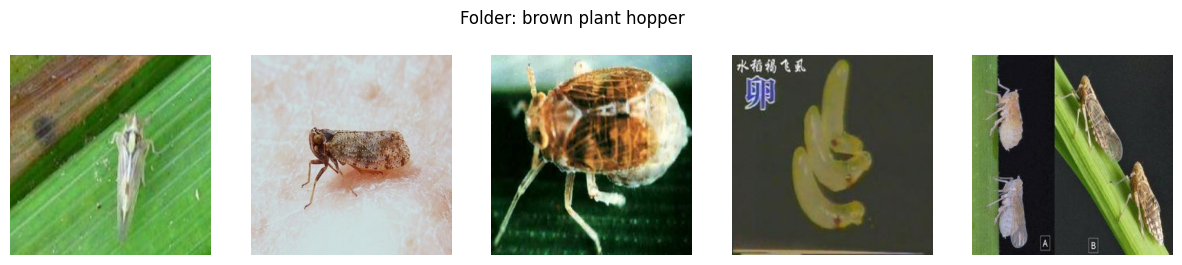

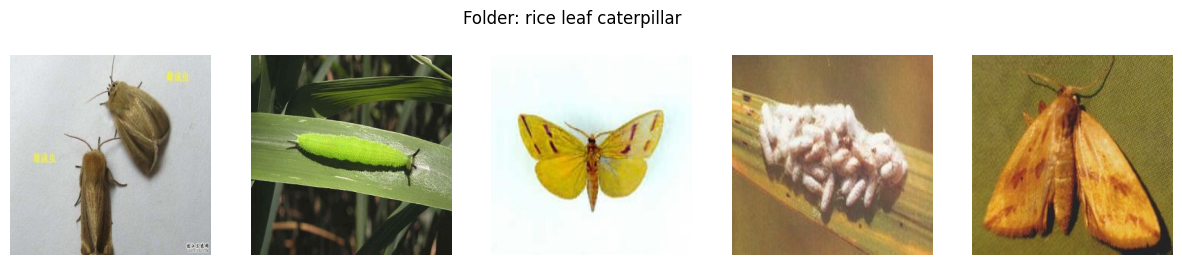

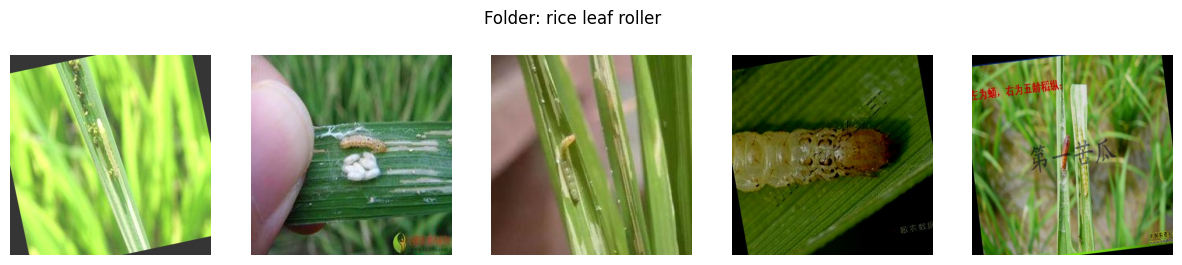

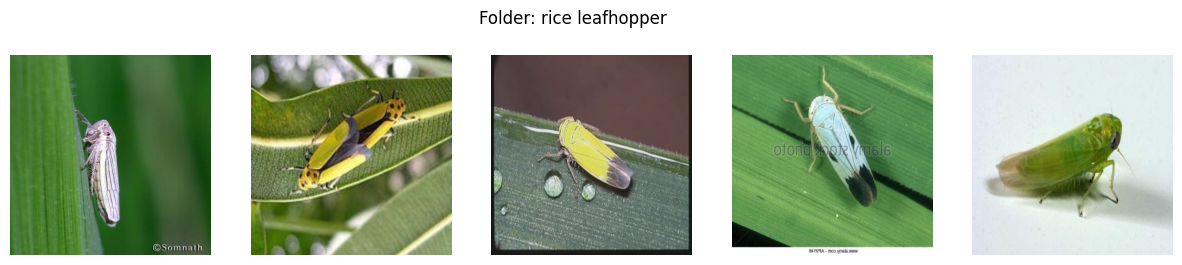

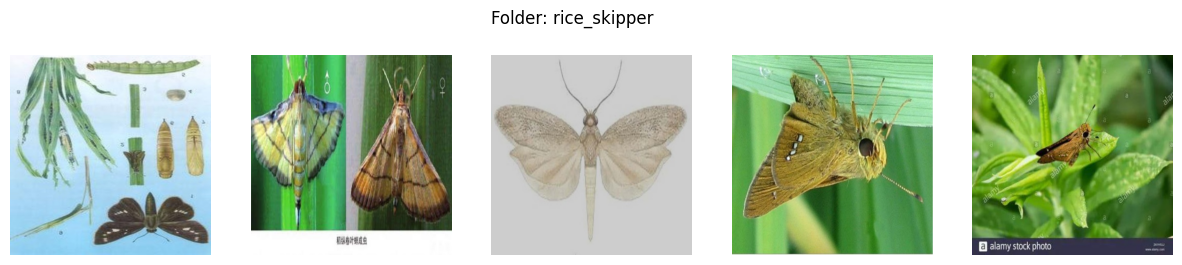

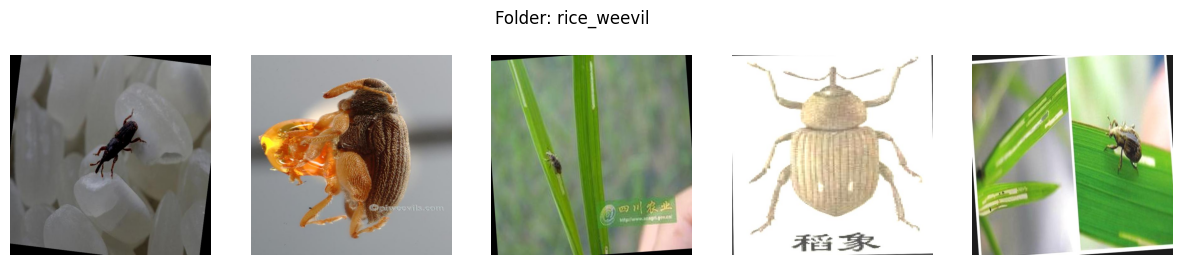

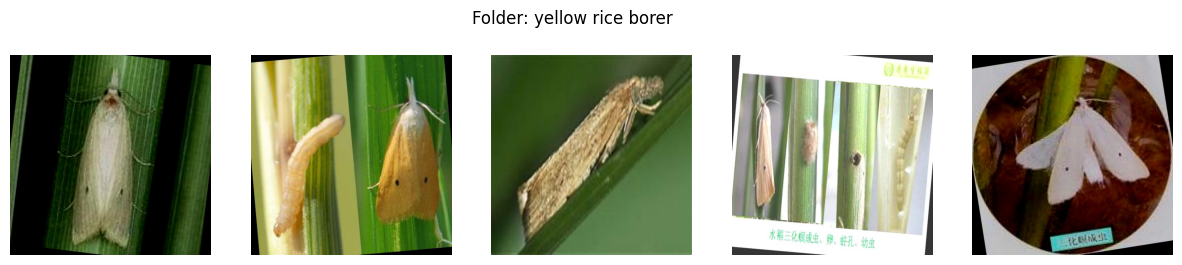

In [11]:
# Display the first 5 images for each unique folder_name
for label in df_balanced['label'].unique():
    df_label = df_balanced[df_balanced['label'] == label].head(5)
    images = df_label['image_path'].tolist()

    # Create a subplot for each image
    plt.figure(figsize=(15, 3))
    for i in range(5):
        plt.subplot(1, 5, i+1)
        img = mpimg.imread(images[i])
        plt.imshow(img)
        plt.axis('off')

    plt.suptitle(f'Folder: {label_encoder.inverse_transform([label])[0]}')
    plt.show()


In [13]:
def preprocess_image(image_path):
  img = cv2.imread(image_path)
  img = cv2.resize(img,(96,96))
  img = img/255.0
  return img

In [14]:
df_balanced['processed_image'] = df_balanced['image_path'].apply(preprocess_image)

In [15]:
train_data, test_data, train_labels, test_labels = train_test_split(
    df_balanced['processed_image'].tolist(),
    df_balanced['label'].tolist(),
    test_size=0.2,
    random_state=42
)

In [16]:
train_data = np.array(train_data)
test_data = np.array(test_data)
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

## CNN MODEL

In [ ]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(7, activation='softmax')
])

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
cnn_history = model.fit(train_data, train_labels, epochs=10, validation_data=(test_data, test_labels))

Epoch 1/10
210/210 [==============================] - 9s 20ms/step - loss: 1.5761 - accuracy: 0.3985 - val_loss: 1.1826 - val_accuracy: 0.6190
Epoch 2/10
210/210 [==============================] - 3s 13ms/step - loss: 0.7657 - accuracy: 0.7469 - val_loss: 0.5782 - val_accuracy: 0.8196
Epoch 3/10
210/210 [==============================] - 3s 13ms/step - loss: 0.3230 - accuracy: 0.9016 - val_loss: 0.4243 - val_accuracy: 0.8887
Epoch 4/10
210/210 [==============================] - 3s 13ms/step - loss: 0.1597 - accuracy: 0.9504 - val_loss: 0.4703 - val_accuracy: 0.8917
Epoch 5/10
210/210 [==============================] - 3s 15ms/step - loss: 0.0621 - accuracy: 0.9814 - val_loss: 0.4681 - val_accuracy: 0.9161
Epoch 6/10
210/210 [==============================] - 3s 14ms/step - loss: 0.0693 - accuracy: 0.9765 - val_loss: 0.5445 - val_accuracy: 0.8976
Epoch 7/10
210/210 [==============================] - 3s 13ms/step - loss: 0.0388 - accuracy: 0.9882 - val_loss: 0.5811 - val_accuracy: 0.9208

In [ ]:
test_loss, test_acc = model.evaluate(test_data, test_labels)
print(f'Test accuracy: {test_acc}')

53/53 [==============================] - 0s 6ms/step - loss: 0.6415 - accuracy: 0.9220
Test accuracy: 0.9220238327980042


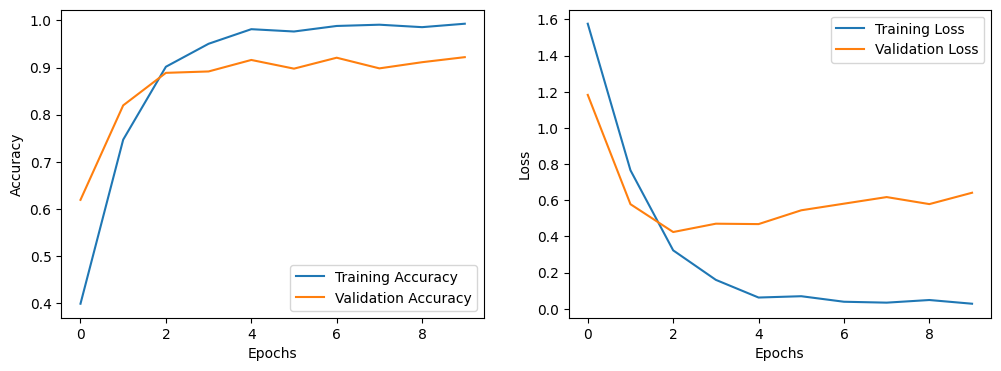

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['accuracy'], label='Training Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['loss'], label='Training Loss')
plt.plot(cnn_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
predictions = model.predict(test_data)
predicted_labels = np.argmax(predictions, axis=1)

cm = confusion_matrix(test_labels, predicted_labels)

53/53 [==============================] - 0s 5ms/step


In [ ]:
class_names = [str(i) for i in range(7)]
print("Classification Report:\n", classification_report(test_labels, predicted_labels, target_names=class_names))

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.89      0.89       254
           1       0.97      1.00      0.98       238
           2       0.84      0.94      0.89       230
           3       0.95      0.89      0.92       243
           4       0.96      0.95      0.95       238
           5       0.91      0.91      0.91       242
           6       0.94      0.89      0.91       235

    accuracy                           0.92      1680
   macro avg       0.92      0.92      0.92      1680
weighted avg       0.92      0.92      0.92      1680



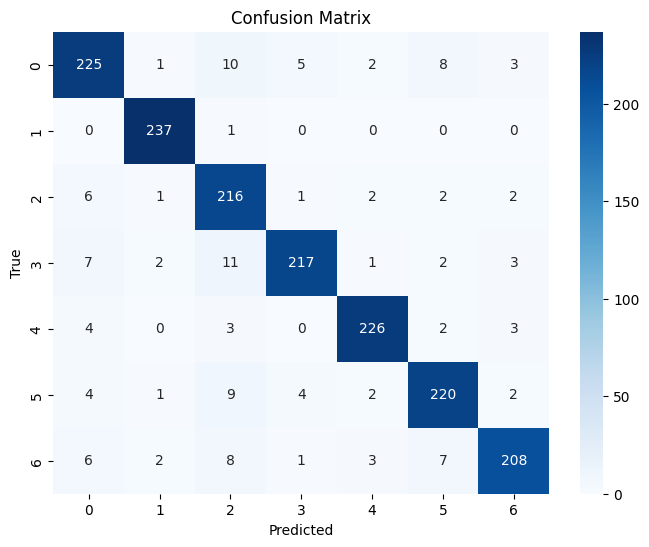

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Got 92% accuracy on CNN model

## Vgg16 MODEL

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(96, 96, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
vgg_model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.1),
    layers.Dense(7, activation='softmax')
])

In [ ]:
vgg_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.03),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
vgg_history = vgg_model.fit(train_data, train_labels, epochs=10, validation_data=(test_data, test_labels))

Epoch 1/10
210/210 [==============================] - 9s 42ms/step - loss: 0.1194 - accuracy: 0.9601 - val_loss: 0.3629 - val_accuracy: 0.9315
Epoch 2/10
210/210 [==============================] - 8s 37ms/step - loss: 0.0885 - accuracy: 0.9744 - val_loss: 0.5161 - val_accuracy: 0.9119
Epoch 3/10
210/210 [==============================] - 8s 38ms/step - loss: 0.0909 - accuracy: 0.9716 - val_loss: 0.5579 - val_accuracy: 0.9024
Epoch 4/10
210/210 [==============================] - 9s 43ms/step - loss: 0.1141 - accuracy: 0.9655 - val_loss: 0.5432 - val_accuracy: 0.9065
Epoch 5/10
210/210 [==============================] - 9s 43ms/step - loss: 0.0913 - accuracy: 0.9708 - val_loss: 0.5498 - val_accuracy: 0.9071
Epoch 6/10
210/210 [==============================] - 9s 42ms/step - loss: 0.1167 - accuracy: 0.9641 - val_loss: 1.0267 - val_accuracy: 0.8274
Epoch 7/10
210/210 [==============================] - 8s 37ms/step - loss: 0.0896 - accuracy: 0.9728 - val_loss: 0.4475 - val_accuracy: 0.9286

In [ ]:
test_loss, test_acc = vgg_model.evaluate(test_data, test_labels)
print(f'Test accuracy: {test_acc}')

53/53 [==============================] - 2s 29ms/step - loss: 0.6517 - accuracy: 0.9167
Test accuracy: 0.9166666865348816


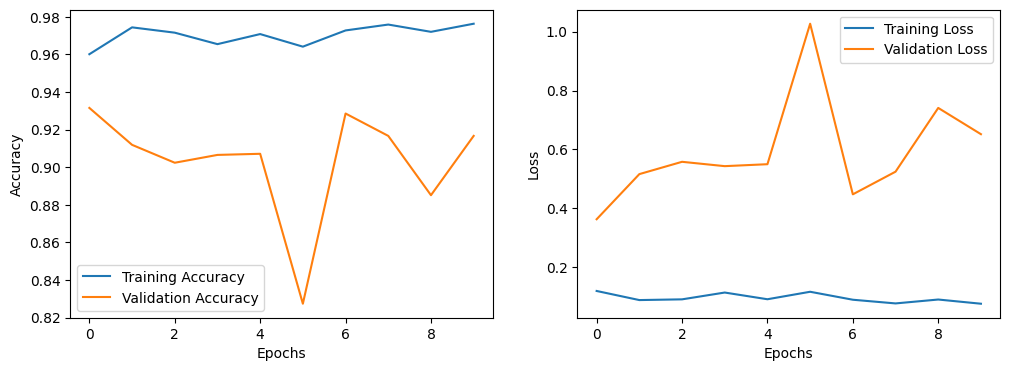

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(vgg_history.history['accuracy'], label='Training Accuracy')
plt.plot(vgg_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(vgg_history.history['loss'], label='Training Loss')
plt.plot(vgg_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
predictions_vgg = vgg_model.predict(test_data)
predicted_labels_vgg = np.argmax(predictions_vgg, axis=1)

cm_vgg = confusion_matrix(test_labels, predicted_labels_vgg)

53/53 [==============================] - 2s 30ms/step


In [ ]:
class_names = [str(i) for i in range(7)]
print("Classification Report:\n", classification_report(test_labels, predicted_labels_vgg, target_names=class_names))

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.94      0.89       254
           1       0.84      1.00      0.91       238
           2       0.92      0.93      0.92       230
           3       0.96      0.77      0.86       243
           4       0.97      0.97      0.97       238
           5       0.96      0.94      0.95       242
           6       0.95      0.86      0.90       235

    accuracy                           0.92      1680
   macro avg       0.92      0.92      0.92      1680
weighted avg       0.92      0.92      0.92      1680



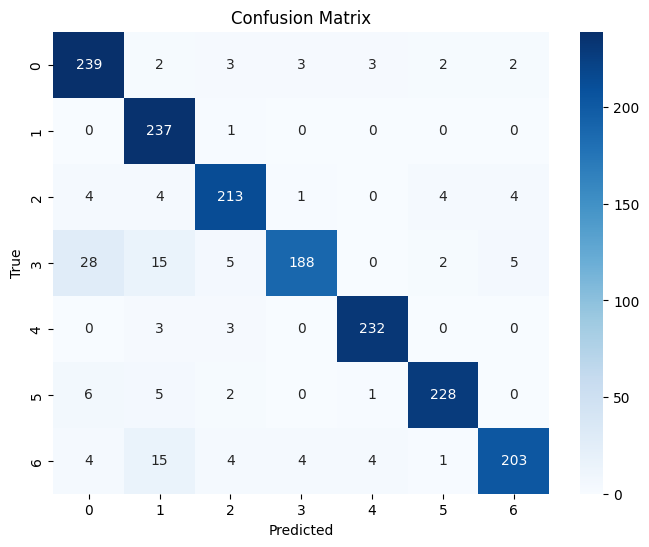

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm_vgg, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Got 91% accuracy on Vgg16 Model

## RESNET50


In [32]:
def create_resnet_model3(input_shape, output_classes):
    # Load ResNet50 model without pre-trained weights
    base_model = ResNet50(weights = None , include_top=False, input_shape=input_shape)


    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    predictions = Dense(output_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    return model

In [33]:
input_shape = (96, 96, 3)
output_classes = 7

resnet_model_no_weights3 = create_resnet_model3(input_shape, output_classes)

In [34]:
resnet_model_no_weights3.compile(optimizer= 'Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [36]:
class StopOnAccuracyAfterEpoch(Callback):
    def __init__(self, target_accuracy=0.95, start_epoch=12):
        super(StopOnAccuracyAfterEpoch, self).__init__()
        self.target_accuracy = target_accuracy
        self.start_epoch = start_epoch

    def on_epoch_end(self, epoch, logs=None):
        if epoch + 1 >= self.start_epoch and logs['val_accuracy'] >= self.target_accuracy:
            print(f"\nReached {self.target_accuracy * 100:.2f}% accuracy, stopping training!")
            self.model.stop_training = True


stop_on_accuracy_after_epoch = StopOnAccuracyAfterEpoch(target_accuracy=0.95, start_epoch=15)

In [37]:
history = resnet_model_no_weights3.fit(train_data, train_labels,
                                      validation_data=(test_data, test_labels),
                                      epochs=28, batch_size=32, shuffle=True,
                                      callbacks=stop_on_accuracy_after_epoch)

Epoch 1/28
210/210 [==============================] - 58s 110ms/step - loss: 1.0094 - accuracy: 0.6749 - val_loss: 5.0911 - val_accuracy: 0.1446
Epoch 2/28
210/210 [==============================] - 21s 101ms/step - loss: 0.4555 - accuracy: 0.8539 - val_loss: 2.3631 - val_accuracy: 0.1369
Epoch 3/28
210/210 [==============================] - 20s 95ms/step - loss: 0.3058 - accuracy: 0.9042 - val_loss: 2.6935 - val_accuracy: 0.1458
Epoch 4/28
210/210 [==============================] - 22s 107ms/step - loss: 0.2579 - accuracy: 0.9195 - val_loss: 1.2048 - val_accuracy: 0.6077
Epoch 5/28
210/210 [==============================] - 21s 100ms/step - loss: 0.1603 - accuracy: 0.9487 - val_loss: 1.3986 - val_accuracy: 0.6899
Epoch 6/28
210/210 [==============================] - 21s 101ms/step - loss: 0.1174 - accuracy: 0.9641 - val_loss: 0.4106 - val_accuracy: 0.8768
Epoch 7/28
210/210 [==============================] - 21s 100ms/step - loss: 0.0836 - accuracy: 0.9750 - val_loss: 0.7156 - val_acc

In [38]:
test_loss, test_acc = resnet_model_no_weights3.evaluate(test_data, test_labels)
print(f'Test accuracy: {test_acc}')

53/53 [==============================] - 2s 28ms/step - loss: 0.2805 - accuracy: 0.9518
Test accuracy: 0.9517857432365417


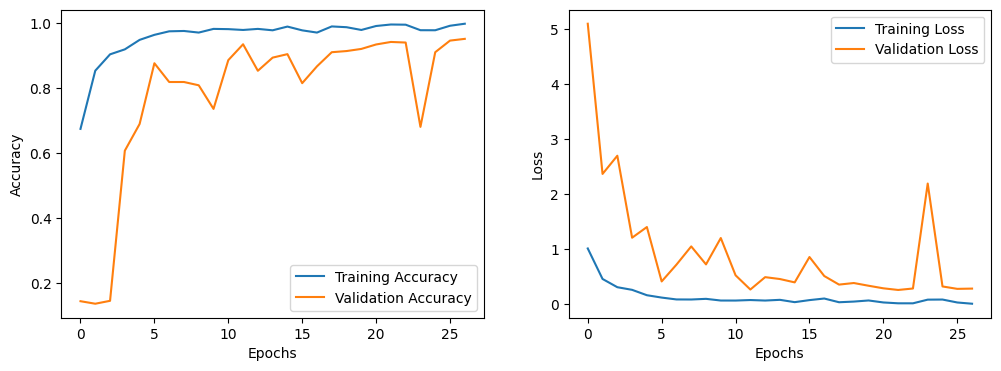

In [39]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [40]:
predictions_res = resnet_model_no_weights3.predict(test_data)
predicted_labels_res = np.argmax(predictions_res, axis=1)

cm_res = confusion_matrix(test_labels, predicted_labels_res)

53/53 [==============================] - 3s 30ms/step


In [41]:
class_names = [str(i) for i in range(7)]
print("Classification Report:\n", classification_report(test_labels, predicted_labels_res, target_names=class_names))

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.93      0.93       254
           1       1.00      1.00      1.00       238
           2       0.99      0.89      0.93       230
           3       0.94      0.95      0.94       243
           4       0.96      0.99      0.98       238
           5       0.90      0.97      0.93       242
           6       0.94      0.94      0.94       235

    accuracy                           0.95      1680
   macro avg       0.95      0.95      0.95      1680
weighted avg       0.95      0.95      0.95      1680



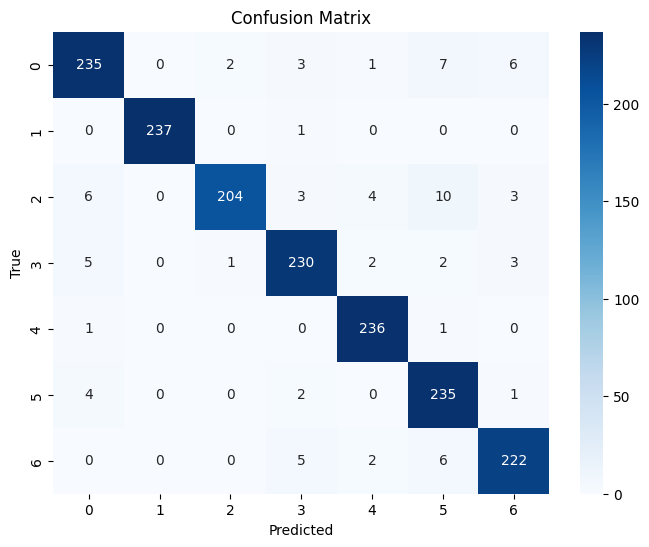

In [42]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm_res, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [45]:
# saving the model into gdrive
save_path_on_drive = '/content/drive/MyDrive/paddy_pest_prediction/'
model_filename = 'resnet_model.h5'
resnet_model_no_weights3.save(save_path_on_drive + model_filename)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Testing using RESNET50


In [66]:
def decode_label(encoded_label):
    return label_encoder.inverse_transform([encoded_label])[0]

def plot_images_and_predictions(images, labels, model):
    plt.figure(figsize=(20, 20))
    for i in range(7):

        folder_data = df_balanced[df_balanced['label'] == i].sample(3, random_state= 42)


        for j, (_, row) in enumerate(folder_data.iterrows()):
            image = row['processed_image']
            true_label = row['label']

            prediction = model.predict(np.expand_dims(image, axis=0))
            predicted_label = np.argmax(prediction)

            plt.subplot(7, 3, i * 3 + j + 1)
            plt.imshow(image)
            plt.title(f'True: {decode_label(true_label)}\nPredicted: {decode_label(predicted_label)}')
            plt.axis('off')

1/1 [==============================] - 0s 51ms/step


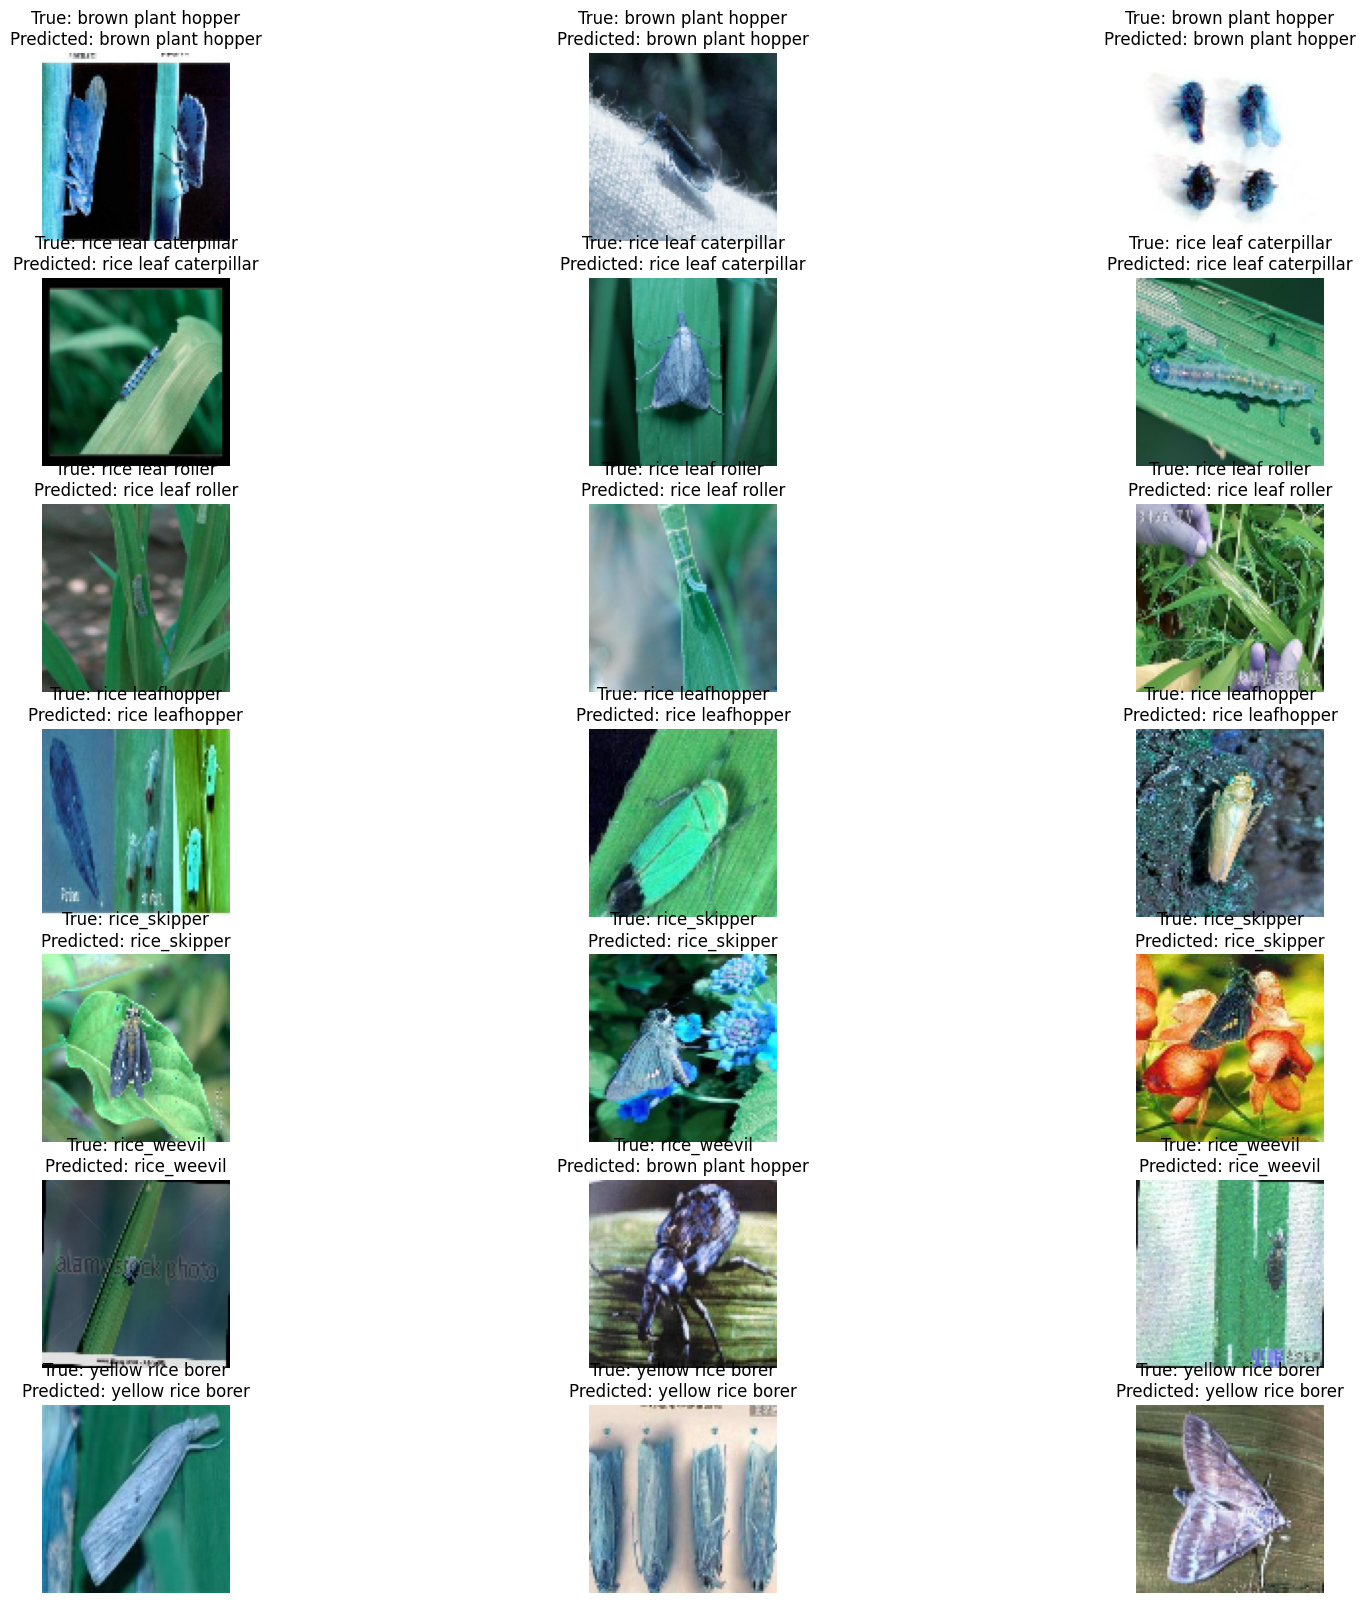

In [67]:
plot_images_and_predictions(test_data, test_labels, resnet_model_no_weights3)